In [1]:
from sklearn.svm import LinearSVC
import numpy as np
from sklearn.model_selection import train_test_split
from dataset import TileDataset
from tqdm import tqdm
import torch
import os
#from siamese_model import EmbeddingNetwork
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


c:\Users\ssk48\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
import torch
import torch.nn as nn

class EmbeddingNetwork(nn.Module):
    def __init__(self, embedding_dim=128):
        super(EmbeddingNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128 * 1 * 1, embedding_dim)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv3(x))
        x = nn.AdaptiveAvgPool2d(1)(x)  # Average pooling for fixed-size output
        x = x.view(x.size(0), -1)
        return nn.functional.normalize(self.fc(x), p=2, dim=1)  # L2 normalized embedding
    
def get_embeddings():
    td = TileDataset("../dataset")
    model = EmbeddingNetwork()
    
    model_path_name = os.path.join("..", "models", "embedding_network.pth")

    weights = torch.load(model_path_name)
    model.load_state_dict(weights)
    model.eval()
    x_train = []
    y_train = []
    grayscale_transform = transforms.Grayscale(num_output_channels=1)

    for i in tqdm(range(len(td))):
        img, label = td.__getitem__(i)
        img = grayscale_transform(img)
        embeddings = model(img.unsqueeze(0)).detach().numpy()

        x_train.append(embeddings)
        y_train.append(label)

    x_train = np.reshape(x_train, (-1, 128))
    np.save(os.path.join("..", "embeddings", "embeddings.npy"), x_train)
    np.save(os.path.join("..", "embeddings", "labels.py"), y_train)
get_embeddings()

100%|██████████| 101297/101297 [01:28<00:00, 1141.20it/s]


In [35]:
x_train = np.load(os.path.join("..", "embeddings", "embeddings.npy"))
y_train = np.load(os.path.join("..", "embeddings", "labels.npy"))
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size=.2)

train_classes = set(list(np.unique(y_train)))
x_train_synth_ex = []
y_train_added_labels = []
for index in range(len(y_test)):
    if y_test[index] not in train_classes:
        train_classes.add(y_test[index])
        x_train_synth_ex.append(x_test[index])
        y_train_added_labels.append(y_test[index])

x_train = np.append(x_train, np.asarray(x_train_synth_ex), axis = 0)
y_train = np.append(y_train, y_train_added_labels)

In [21]:
from sklearn.metrics import f1_score
def get_top_k_acc(clf, k):
    num_correct = 0
    for feat, label in tqdm(zip(x_test, y_test)):
        probs = clf.predict_proba(feat.reshape(1, -1))[0]
        indices = np.argsort(probs)[::-1]
        top_k_labels = clf.classes_[indices[:k]]
        if label in top_k_labels:
            num_correct += 1
    return num_correct / len(x_test)

def get_f1_score(clf, x, y_true):
    y_pred = clf.predict(x)
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

def evaluate_model(clf, k, train=True, test=True, top_k=True):
    train_f1, test_f1, top_k_acc = None, None, None
    if train:
        train_f1 = get_f1_score(clf, x_train, y_train)
    if test:
        test_f1 = get_f1_score(clf, x_test, y_test)
    if top_k:
        top_k_acc = get_top_k_acc(clf, k)
    return train_f1, test_f1, top_k_acc

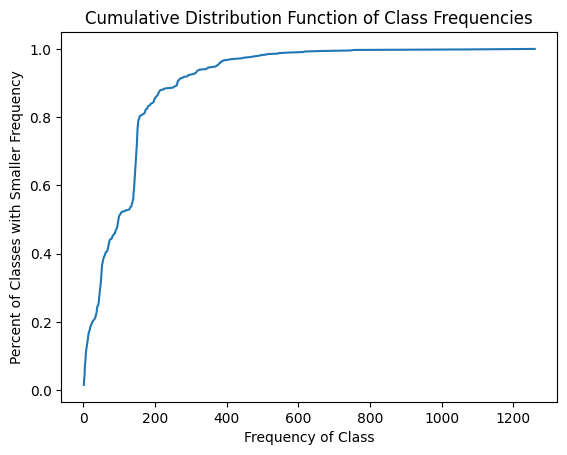

In [22]:
vals, freqs = np.unique(y_train, return_counts=True)

x, counts = np.unique(freqs, return_counts=True)
cusum = np.cumsum(counts)
plt.plot(x, cusum/ cusum[-1])
plt.xlabel("Frequency of Class")
plt.ylabel("Percent of Classes with Smaller Frequency")
plt.title("Cumulative Distribution Function of Class Frequencies")
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0,
    max_depth=2, max_features ="log2", random_state=0)
clf.fit(x_train, y_train)

train_f1, test_f1, _ = evaluate_model(clf, 5, x_train, y_train, top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

In [36]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=1, weights="distance", metric="cosine")
clf.fit(x_train, y_train)
train_f1, test_f1, _ = evaluate_model(clf, 5, top_k=False)
print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

Train F1 Score: 0.9363495711195495
Test F1 Score: 0.3850660748410848


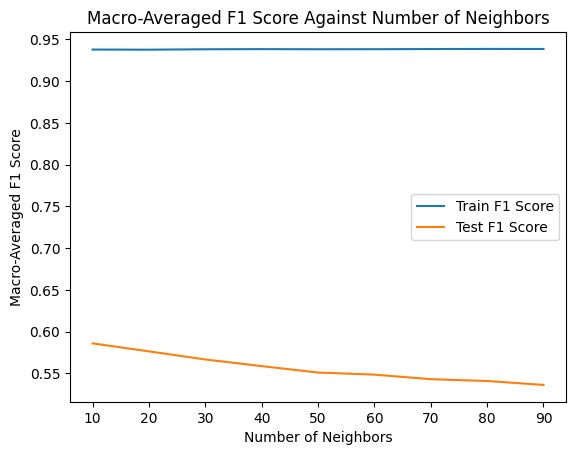

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
train_f1s = []
test_f1s = []
n_neighbors_range = range(10, 100, 10)
for n_neighbors in n_neighbors_range:
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights="distance", metric="cosine")
    clf.fit(x_train, y_train)
    train_f1, test_f1, _ = evaluate_model(clf, 5, top_k=False)
    train_f1s.append(train_f1)
    test_f1s.append(test_f1)

plt.plot(n_neighbors_range,
         train_f1s)
plt.plot(n_neighbors_range,
         test_f1s)
plt.xlabel("Number of Neighbors")
plt.ylabel("Macro-Averaged F1 Score")
plt.title("Macro-Averaged F1 Score Against Number of Neighbors")
plt.legend(["Train F1 Score", "Test F1 Score"])

In [14]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train, y_train)
train_f1, test_f1, _ = evaluate_model(clf, 5, top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

c:\Users\ssk48\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train F1 Score: 0.2520568743140576
Test F1 Score: 0.2619235503911677


In [24]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (64, 64), max_iter = 1000,random_state=1)
clf.fit(x_train, y_train)

train_f1, test_f1, _ = evaluate_model(clf, 5, top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")


c:\Users\ssk48\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Train F1 Score: 0.6935410650274646
Test F1 Score: 0.5813755262518263


In [15]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=25, random_state=0)
clf.fit(x_train, y_train)
train_f1, test_f1, _ = evaluate_model(clf, 5, top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

Train F1 Score: 0.9187353621034196
Test F1 Score: 0.5947388393316027


In [ ]:
clf = LinearSVC()
clf.fit(x_train, y_train)

train_f1, test_f1, _ = evaluate_model(clf, 5,  top_k=False)

print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

In [ ]:
import pickle
clf_model_path = os.path.join("..", "models", "model.pkl")
with open(clf_model_path ,'wb') as f:
    pickle.dump(clf,f)

In [4]:
from PIL import Image
td = TileDataset("../dataset")
x_train = []
y_train = []
for i in tqdm(range(len(td))):
    img, label = td.__getitem__(i)
    x_train.append(img.reshape(-1).detach().numpy())   
    y_train.append(label)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)



  0%|          | 0/101297 [00:00<?, ?it/s]

torch.Size([3, 8, 8])


(101297, 192)


In [60]:
from PIL import Image
image  = np.reshape(x_train[0], (8, 8, 3))*255 
image = image.astype(np.uint8)
print(image.shape)
image = Image.fromarray(image)
image.show()

(8, 8, 3)


In [42]:
x_train, x_test, y_train, y_test = train_test_split(x_train,y_train, test_size=.2)
clf = KNeighborsClassifier(n_neighbors = 5, p =2)
clf.fit(x_train, y_train)
train_f1, test_f1, _ = evaluate_model(clf, 5,  top_k=False)
print(f"Train F1 Score: {train_f1}")
print(f"Test F1 Score: {test_f1}")

KeyboardInterrupt: 

In [40]:
import pickle
clf_model_path = os.path.join("..", "models", "model.pkl")
with open(clf_model_path ,'wb') as f:
    pickle.dump(clf,f)

